In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])

# Now to apply CARPoolGP to Data

We want to apply the CARPoolGP method to a set of extracted data. Here we use the extracted blackhole mass from the CAMELS zoom in simulations

## 1. Generate a set of parameters, $B$, at which to extract Base sample quantities $\tilde{Q}$

I have saved the currently used parameters from the sims in the ```Data/GZ23_params.csv``` file. So you can access this easily.

In [2]:
import pandas as pd
data = np.load('Data/BHMass.npz')
param_df = pd.read_csv('Data/GZ28_params.csv', index_col=0)
param_info = pd.read_csv('Data/GZ28_param_minmax.csv', index_col=0)

theta_raw = np.asarray(param_df.iloc[:, :29])
Mass = data['M']
Mass[Mass==0] = np.random.uniform(np.mean(Mass[Mass!=0]),np.std(Mass[Mass!=0]), len(Mass[Mass==0]))
theta_raw[:, -1] = np.log10(Mass)

We also need to account for the parameters that have been logged, It is also good to normalize the data, this way we dont get a sing parameter that is doing all the work

In [3]:
import pandas as pd
theta = theta_raw.copy()
for i, t in enumerate(theta_raw[:, :-1].T):
    if bool(param_info['LogFlag'][i]):
        theta[:, i] = np.log10(theta_raw[:, i])

In [4]:
def normalize_Y(val):
    return (val - np.mean(val)) / np.std(val)
def unnormalize_Y(val, std, mean):
    return val * std + mean
def normalize_X(val, param=None):
    if param is None:
        return (val - fids) / np.abs(lbs-ubs)
    else:
        return (val - fids[param]) / np.abs(lbs[param] - ubs[param])
def unnormalize_X(val, param=None):
    if param is None:
        return val* np.abs(lbs-ubs) + fids
    else:
        return val * np.abs(lbs[param] - ubs[param]) + fids[param]

We need to find the bounds of our parameters for normalizing them

In [5]:
lbs = []
ubs = []
fids = []
for i in param_info.T:
    if param_info.loc[i, 'LogFlag'] ==1:
        lbs.append(np.log10(param_info.loc[i, "MinVal"]))
        ubs.append(np.log10(param_info.loc[i, "MaxVal"]))
        fids.append(np.log10(param_info.loc[i, "FiducialVal"]))

    else:
        lbs.append(param_info.loc[i, "MinVal"])
        ubs.append(param_info.loc[i, "MaxVal"])
        fids.append(param_info.loc[i, "FiducialVal"])

lbs.append(13.0)
ubs.append(14.5)
lbs = np.array(lbs)
ubs = np.array(ubs)
fids.append(13.75)
fids = np.array(fids)


In [6]:
def get_BHM(theta):
    """_summary_

    Args:
        theta (array): parameter space locations should be (768, 29) shape
        ii (integer): the radius bin that we are emulating. 

    Returns:
        usable_theta_normalized: normalized parameter space coordinates where quantity is not nan or 0
        Y                      : Normalized quantity that we are emulating
        zoom_num               : Array of zoom numbers that are being used with quantity not nan or 0
        np.std(xraySB)         : the standard deviation of the data (that is not 0 or nan) to unnormalize later
        np.mean(xraySB)        : the mean of the data (that is not 0 or nan) to unnormalize later
    """
    # Organize the data a bit
    data = np.load('Data/BHMass.npz')
    BHM = data['BHM'][:]
    
    # Some values might be 0 or nan, but we dont want those in our training
    usable_indices = np.where(BHM[:]>0) 
    BHM=BHM[usable_indices]

    # Normalize the data
    Y      = normalize_Y(BHM)
    Mass     = data['M'][usable_indices]
    zoom_num = data['N'][usable_indices].astype(int)

    
    usable_theta        = theta[zoom_num]
    usable_theta[:, -1] = Mass
    usable_theta_normalized = normalize_X(usable_theta) #Normalizes to between -1 and 1
    
    return usable_theta_normalized, Y, zoom_num, np.std(BHM), np.mean(BHM)

In [7]:
theta_norm, Y, N, BH_std, BH_mean = get_BHM(theta)

## 2. Generate a set $S$ of Parameter Islands, $\theta_{S}$ at which to extract Surrogate sample quantities, $\tilde{Q}^S$. Ensure that Base-Surrogate pairs have some level of correlation between them. 


The above gave us 512 parameter lines, but not all of these are Base simulations. Some correspond to surrogates. So we need to seperate them appropriately. This is made easy, because we have a flag in param_df for surrogates
IF (line // 128 ) Mod 2 == 0: Base

In [8]:
theta_B_norm = theta_norm[np.isnan(param_df.loc[N, 'Surrogate'])]
theta_S_norm = theta_norm[~np.isnan(param_df.loc[N, 'Surrogate'])]

We now want to read the data in from your file. So read it in and split it in the same way. There should be a dataset for the theta_B and a dataset for theta_S.

It is not completely necessary, but it helps if you line pairs of data up, i.e. Q_S[i] is the surrogate of Q_B[i]. If one or the other does not exist, then place them at the end of the array. I show an example below for a different quantity. 

In [9]:
Q_B_norm = Y[np.isnan(param_df.loc[N, 'Surrogate'])]
Q_S_norm = Y[~np.isnan(param_df.loc[N, 'Surrogate'])]

Some of the Y values are not missing here, as there are a few simulations not done, so we replace these with small random values. We also log and normalize all of the values. 

## 3. Determine the noise kernels and associated hyperparameters for Base, Surrogate, and Combined quantities: $C_{ij}$, $D_{ij}$, $X_{ij}$.


We are going to use the same kernels as in the toy example, but with extra dimensions on the parameters. So all we need to do is generate the simulation, surrogate, and emulation objects:


In [10]:
from src import CARPoolSimulations, CARPoolEmulator

In [11]:
# Create simulation objects and surrogate objects
sims = CARPoolSimulations.Simulation()
surrs = CARPoolSimulations.Simulation()

# Set the parameters and quantities for these simulations
sims.parameters  = theta_B_norm ;  sims.quantities  =Q_B_norm
surrs.parameters = theta_S_norm ;  surrs.quantities =Q_S_norm

## 4. Maximize the likelihood function to obtain the optimal set of hyperparameters: $\hat{\tau}$.

We need to generate some initial guess of the parameters, and then we can emulate! feel free to mess around with the initial conditions, as the minimization can be sensitive to this sometimes. 

In [14]:
#Build an emulator object (this generates the kernels which you can find in the CARPoolKernels file) 
emu = CARPoolEmulator.Emulator(sims, surrs)

params = {"log_scaleV"   :1*np.ones(emu.param_dimensions),
        "log_scaleM" :1*np.ones(emu.param_dimensions),
        "log_ampV"   :0.0,          
        "log_jitterV":-1.0,
        "log_mean"   :0.0}

best_params = emu.train(params,learning_rate=0.1, max_iterations=100)

Text(0, 0.5, '$\\Delta \\mathcal{L}$')

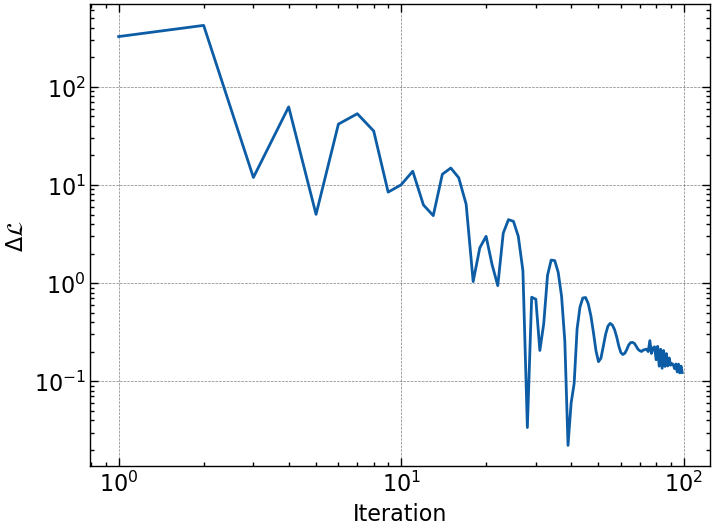

In [19]:
plt.loglog(np.abs(np.diff(emu.losses)))
plt.xlabel('Iteration')
plt.ylabel(r'$\Delta \mathcal{L}$')

## 5. Emulate to find $ Q(\theta_{p, i}')$, and $\sigma^2(\theta_{p, i}', \theta_{p,j}')$.

If for example we want to emulate the black hole mass as a function of the mass, but at different values of Omega_m, we can do this!

In [115]:
def predict_M(P, emu, mean, std):
    """predict BHM as a function of halo mass, for high, fuducial and low parameter bounds while all other parameters are at fiducial.
    Args:
        P (int): The parameter number that you want to modulate
        emu (object): the emulator 
        means (array): the mean of the quantity
        stds (array): the std of the quantity

    Returns:
        ms: the emulated prediction
        vs: the emulated covariance matrix
    """
    
    # normalize the theta positions at the upper and lower bounds
    l = normalize_X(lbs[P], P)
    u = normalize_X(ubs[P], P)
    ms, stds = [], []

    # Generate a parameter space location, which is at the fiducial location in parameter space
    for i in [l, 0, u]:
        test_theta = np.zeros((1000, 29))
        test_theta[:, 14] = normalize_X(fids[14], 14) # WindSpecMomentum is actually fiducial at 0
        test_theta[:, P] = i # We now have 3 parameter space location we are testing, when P is at lb, fid and ub
        test_theta[:, -1] = np.linspace(normalize_X(lbs[28], 28), normalize_X(ubs[28], 28), 1000)
        x = unnormalize_X(test_theta[:, -1], 28)
   
        # Now for each bin, emulate the value, and unnormalize
    
        m, v = emu.predict(test_theta)
        m  = unnormalize_Y(m, std, mean)
        v= v* std**2 
        ms.append(m)
        stds.append(np.diag(v)**(0.5))
    return np.array(ms), np.array(stds), x

Text(0.5, 1.0, 'Omega0')

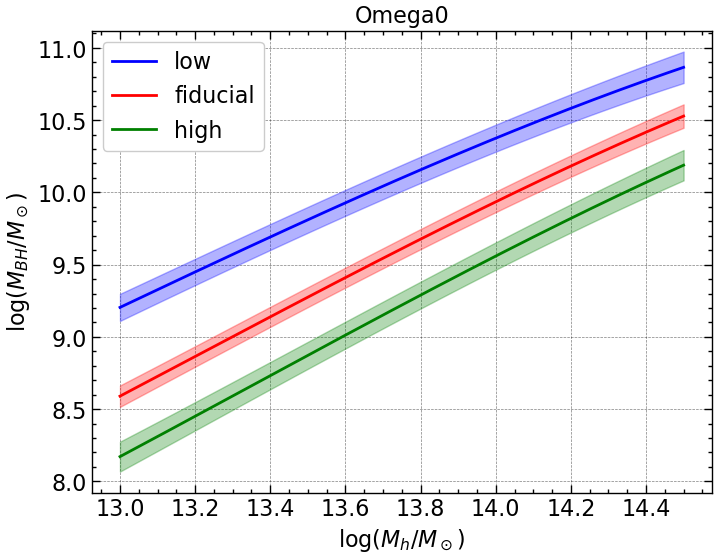

In [116]:
P = 0
ms, stds, x = predict_M(P, emu, BH_mean, BH_std)
cs = ['b', 'r', 'g']
labels = ['low', 'fiducial', 'high']
for i in range(3):
    plt.plot(x, ms[i], c=cs[i], label=labels[i])
    plt.fill_between(x, ms[i]- stds[i], ms[i] + stds[i], alpha=0.3, color=cs[i])
    
plt.legend()
plt.xlabel(r'$\log(M_h/M_\odot)$')
plt.ylabel(r'$\log(M_{BH}/M_\odot)$')
plt.title(param_info.ParamName[P])